## Introduction to accessing Sentinel-3 data on the Amazon Registry of Open Data

Thanks to the support of [Amazon Web Service Public Dataset Program](https://aws.amazon.com/opendata/public-datasets/), [MEEO](www.meeo.it) as part of it's [ADAM Platform](https://adamplatform.eu/) project has created an archive of Sentinel-3 Level 2 data on the [Registry of Open Data on AWS](https://registry.opendata.aws/) (RODA). This data is Open Data and then available to anyone. In this tutorial we provide a simple example of how anyone can access the data, download a file and visualise the contents of the file. 

## Quick overview

The Sentinel-3 mission is composed of two twin satellites (Sentinel-3A and Sentinel-3B) designed by the [European Space Agency](https://earth.esa.int/web/guest/missions/esa-eo-missions/sentinel-3) (ESA) and funded by the European Commission's [Copernicus Programme](https://www.copernicus.eu/en).The main objective of the Sentinel-3 mission is to measure sea surface topography, sea and land surface temperature, and ocean and land surface colour with high accuracy and reliability to support ocean forecasting systems, environmental monitoring and climate monitoring. 
It is a polar orbiting satellite that completes 14 orbits of the Earth a day. Sentinel-3 carries two major instruments:

• Ocean and Land Colour Instrument (OLCI) for medium resolution marine and terrestrial optical measurements.

• Sea and Land Surface Temperature Radiometer (SLSTR) for marine and terrestrial thermal measurements.


MEEO have made several key products from the Sentinel-3 programme available on **RODA**. A full description of the contents of the data archive can be found [here](https://git.services.meeo.it/delaney/meeo_aws_roda/-/blob/master/Sentinel-3/DocsForAws/Sentinel3Description.md). In this tutorial we are going to look at the Sentinel-3 **Land Surface Temperature** data obtained as a Level-2 product of the SLSTR sensor.

The Sentinel-3 stored on Amazon is contained in a bucket (a container for data) which can be browsed [here](https://meeo-s3.s3.amazonaws.com/index.html#/?t=catalogs).

This tutorial will show how to use Python to visualise the data. We are using a [Jupyter notebook](https://jupyter.org/) to present the tutorial.

Required installations:

- Python 3 and Jupyter Notebook ([Anaconda](https://www.anaconda.com/distribution/) is a convenient distribution).
- Python Libraries: gdal, cartopy, rasterio and netcdf4. 

If you do install Anaconda, open a cmd box and type   etc.

- 'conda install -c conda-forge gdal'
- 'conda install -c conda-forge cartopy'
- 'conda install -c conda-forge rasterio'
- 'conda install -c conda-forge netcdf4'

This may take some time, depending on the speed of your computer and Internet connection.

## Browsing the catalogue and getting the first file

We have provided a COG catalogue to the bucket which is available [here](https://meeo-s3-cog.s3.amazonaws.com/index.html#/?t=catalogs).

Navigate the bucket by clicking on the links. Here is the path for the beginning of this example. 

<font color='red'>Non Time Critical(**NTC**)</font> **-->** 
<font color='red'>Sentinel-3A(**S3A**)</font> **-->** 
<font color='red'>SLSTR Level 2 LST(**SL_2_LST___**)</font> **-->** 
<font color='red'>**2020**</font> **-->** 
<font color='red'>**03**</font> **-->** 
<font color='red'>**04**</font> **-->** 
<font color='red'>Product directory( **S3A_SL_2_LST____20200304T092452_20200304T110552_20200305T161805_6059_055_307______LN2_O_NT_004.SEN3**)</font> **-->**

Following this path will lead to downloading this file:

<font color='blue'>**S3A_SL_2_LST____20200304T092452_20200304T110552_20200305T161805_6059_055_307______LN2_O_NT_004_LST.tif**</font>

Store this file on your local computer. It is an image file of the Land Surface Temperature retrieved from the Sentinel-3A SLSTR data.

## Visualizing the Sentinel-3 Land Surface Temperature from the COG data format

In this section we visualise the data in COG format file that you have just downloaded and stored locally on your computer.  To do this you will need to open a Jupyter Notebook and copy the code, contained in each of the boxes below, into it.


In [2]:
import cartopy.crs as ccrs
import rasterio
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from rasterio.plot import show

# For convenience I have stored the COG file in the same directory as this notebook.
# Note you may have given the file a different name.

raster = rasterio.open('E:/JD/git_repos/Clone/data-on-s3-Jalpesh/notebooks/20221201_LST.tif')

# This will print out a short version of the  meta data associated with this file.
print(raster.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1501, 'height': 1292, 'count': 6, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1143.2945182564595, 0.0, -265608.4238358707,
       0.0, -1143.2945182564595, 3497160.729315155)}


So above is the meta data assciated with this file. The rasterio raster object contains all the meta data that we need and we will use it below.

In [3]:
# Data visualization units.
unit = '[ K ]'

long_name = 'Sentinel-3 Land Surface Temperature'

# We need to know the geographical extent of the data, this is contained in the raster object.

bbox = raster.bounds
extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
print (bbox)

BoundingBox(left=-265608.4238358707, bottom=2020024.2117278096, right=1450476.6480670748, top=3497160.729315155)


As the product has a very large dimension, we apply a rescaling factor to it, reducing the size with a 1/10 factor, to get an amount of data that can be better handled for a web application.

In [4]:
from rasterio.enums import Resampling

upscale_factor = 0.1

# resample data to target shape
data = raster.read(
out_shape=(
    raster.count,
    int(raster.height * upscale_factor),
    int(raster.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
transform = raster.transform * raster.transform.scale(
(raster.width / data.shape[-1]),
(raster.height / data.shape[-2]))

print('Rescaled size: ',np.shape(data[0,:,:]))

Rescaled size:  (129, 150)


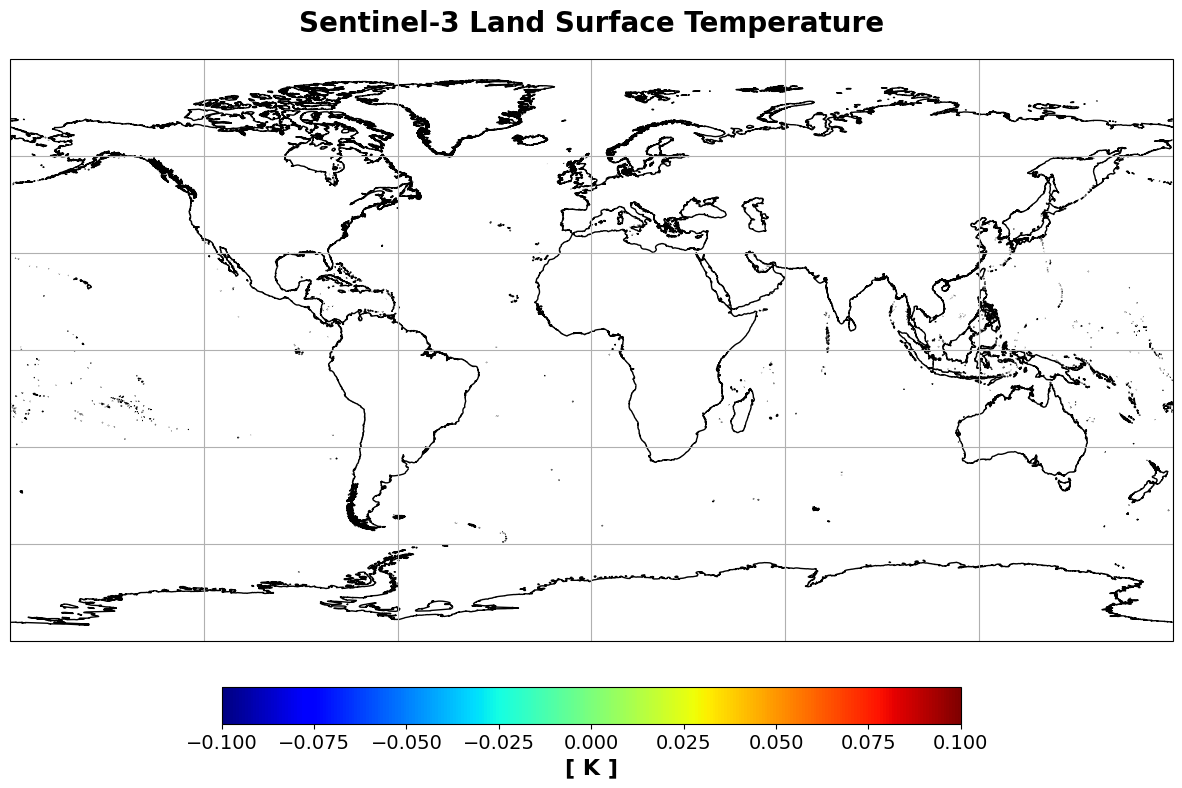

In [6]:
# Here we set up the parameters needed to display the geographical data correctly.
fig=plt.figure(figsize=(15, 12))

# Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.

ax = plt.axes(projection=ccrs.PlateCarree())

# The coastline data get downloaded here, there may be a delay the first time you run this notebook.

ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

# Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
# selecting which colour to associate with the NODATA value in the map

color = cm.jet

color.set_bad('white')

#The pixel associated to the NODATA values are masked out.

# data = data.astype(np.float16)
# data[data == -32768.0] = np.nan

# As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
# These can be retrieved from the extended metadata of the file. 

# scale_factor = 0.0020000001

# offset = 290

# cal_data = scale_factor * data + offset

img = plt.imshow(data[0,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
cbar.set_label(unit, fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=14)
plt.savefig('lst.png')
plt.show()